## Setup

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
keras = tf.keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt
import jsonpickle
import os
import math
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
# CONSTANTS

# file paths
root_path = '/content/drive/MyDrive/sisi/'
labels_file = root_path + 'out_labels.json'
data_file =  root_path + 'out_normalized_glyphs.json'

# RNN specific
SHAPE = (392, 2) # best = (392, 2), tried (784, 1), (28, 28), (2, 392) shape of data for RNN

## Loading the data

In [5]:
# LOADING THE LABELS
#
# Usage:
#   labels_str - list of labels in order, as strings: a, a, b, b, c, c...
#   labels_int - list of labels in order, as ints: 0, 0, 1, 1, 2, 2...
#   label_str_dict['a'] returns 0
#   class_names[0] returns 'a'
#   class_amount - total amount of classes (97)

with open(labels_file, 'r') as file:
    labels_str = jsonpickle.decode(file.read())

label_str_dict = {}

def label_str_to_int(label):
    if label not in label_str_dict:
        i = len(label_str_dict)
        label_str_dict[label] = i
    return label_str_dict[label]

labels_int = [ label_str_to_int(label) for label in labels_str ]

class_names = [ list(label_str_dict.keys())[list(label_str_dict.values()).index(i)] for i in range(len(label_str_dict)) ]
class_amount = len(class_names)

# labels_onehot = tf.one_hot(labels_int, depth=class_amount) unused

In [6]:
def split_data(data, labels, idx=100):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    for l in range(len(set(labels))):
        label_images = data[labels == l]
        train_data.extend(label_images[:idx])
        train_labels.extend([l]*idx)
        test_data.extend(label_images[idx:])
        test_labels.extend([l]*(len(label_images) - idx))
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)

In [7]:
def process_data(data):
    data_flattened = [[item for sublist in l for item in sublist] for l in glyphs]
    data_padded = tf.keras.utils.pad_sequences(data_flattened, padding='post', dtype='float32')
    return np.reshape(data_padded, (data_padded.shape[0], SHAPE[0], SHAPE[1]))

In [8]:
with open(data_file, 'r') as file:
    glyphs = (jsonpickle.decode(file.read()))

In [9]:
glyphs_processed = process_data(glyphs)

In [10]:
x_train, y_train, x_test, y_test = split_data(glyphs_processed, np.array(labels_int))

## Creating a model

In [11]:
def dump_res(history):
    print(max(history['val_accuracy']), history['val_accuracy'])
    print(max(history['accuracy']), history['accuracy'])
    print(min(history['val_loss']), history['val_loss'])
    print(min(history['loss']), history['loss'])

In [12]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=SHAPE, dtype="float32"))
 # masking so that GRU knmows zeros are padding
model.add(tf.keras.layers.Masking(mask_value=0.))

# GRU (Gated recurrent unit) - varaint of RNN
model.add(tf.keras.layers.GRU(256, activation='tanh', return_sequences=True))
model.add(tf.keras.layers.GRU(256, activation='tanh', return_sequences=True))
model.add(tf.keras.layers.GRU(256, activation='tanh'))

# classifier 'hat'
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(97, activation='softmax'))

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics=['accuracy']

model.compile(loss=loss, optimizer=optim, metrics=metrics)

## Training a model

In [13]:
batch_size = 64
epochs = 150
hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(x_test, y_test))

Epoch 1/150
152/152 - 28s - loss: 4.3554 - accuracy: 0.0236 - val_loss: 3.9690 - val_accuracy: 0.0598 - 28s/epoch - 186ms/step
Epoch 2/150
152/152 - 5s - loss: 3.7895 - accuracy: 0.0694 - val_loss: 3.5079 - val_accuracy: 0.1082 - 5s/epoch - 34ms/step
Epoch 3/150
152/152 - 5s - loss: 3.2766 - accuracy: 0.1302 - val_loss: 2.9892 - val_accuracy: 0.1835 - 5s/epoch - 35ms/step
Epoch 4/150
152/152 - 6s - loss: 2.5757 - accuracy: 0.2575 - val_loss: 2.1904 - val_accuracy: 0.3784 - 6s/epoch - 41ms/step
Epoch 5/150
152/152 - 5s - loss: 1.8874 - accuracy: 0.4249 - val_loss: 1.5442 - val_accuracy: 0.5464 - 5s/epoch - 34ms/step
Epoch 6/150
152/152 - 8s - loss: 1.4551 - accuracy: 0.5491 - val_loss: 1.3032 - val_accuracy: 0.6201 - 8s/epoch - 55ms/step
Epoch 7/150
152/152 - 5s - loss: 1.1462 - accuracy: 0.6330 - val_loss: 1.0265 - val_accuracy: 0.6995 - 5s/epoch - 35ms/step
Epoch 8/150
152/152 - 7s - loss: 0.8985 - accuracy: 0.7089 - val_loss: 0.9231 - val_accuracy: 0.7371 - 7s/epoch - 44ms/step
Epoch

## Training results

In [14]:
dump_res(hist.history)

0.873711347579956 [0.05979381501674652, 0.10824742168188095, 0.18350514769554138, 0.37835052609443665, 0.5463917255401611, 0.620103120803833, 0.6994845271110535, 0.7371134161949158, 0.7706185579299927, 0.7907216548919678, 0.8237113356590271, 0.8103092908859253, 0.8195876479148865, 0.8159793615341187, 0.8355669975280762, 0.8371133804321289, 0.8242267966270447, 0.8438144326210022, 0.8520618677139282, 0.8350515365600586, 0.8453608155250549, 0.839175283908844, 0.8278350234031677, 0.8298969268798828, 0.8469071984291077, 0.8386598229408264, 0.8293814659118652, 0.8556700944900513, 0.8494845628738403, 0.8556700944900513, 0.8505154848098755, 0.8505154848098755, 0.8417525887489319, 0.8510309457778931, 0.8479381203651428, 0.8448453545570374, 0.8546391725540161, 0.8530927896499634, 0.8298969268798828, 0.8463917374610901, 0.8603093028068542, 0.8510309457778931, 0.8628866076469421, 0.853608250617981, 0.8597938418388367, 0.8597938418388367, 0.807216465473175, 0.8432989716529846, 0.8551546335220337, 0

In [15]:
#0.873711347579956 [0.05979381501674652, 0.10824742168188095, 0.18350514769554138, 0.37835052609443665, 0.5463917255401611, 0.620103120803833, 0.6994845271110535, 0.7371134161949158, 0.7706185579299927, 0.7907216548919678, 0.8237113356590271, 0.8103092908859253, 0.8195876479148865, 0.8159793615341187, 0.8355669975280762, 0.8371133804321289, 0.8242267966270447, 0.8438144326210022, 0.8520618677139282, 0.8350515365600586, 0.8453608155250549, 0.839175283908844, 0.8278350234031677, 0.8298969268798828, 0.8469071984291077, 0.8386598229408264, 0.8293814659118652, 0.8556700944900513, 0.8494845628738403, 0.8556700944900513, 0.8505154848098755, 0.8505154848098755, 0.8417525887489319, 0.8510309457778931, 0.8479381203651428, 0.8448453545570374, 0.8546391725540161, 0.8530927896499634, 0.8298969268798828, 0.8463917374610901, 0.8603093028068542, 0.8510309457778931, 0.8628866076469421, 0.853608250617981, 0.8597938418388367, 0.8597938418388367, 0.807216465473175, 0.8432989716529846, 0.8551546335220337, 0.8489691019058228, 0.8350515365600586, 0.8510309457778931, 0.8556700944900513, 0.8685566782951355, 0.8541237115859985, 0.8520618677139282, 0.8432989716529846, 0.8376288414001465, 0.8597938418388367, 0.8479381203651428, 0.8623711466789246, 0.853608250617981, 0.8592783212661743, 0.8644329905509949, 0.8608247637748718, 0.8587628602981567, 0.8530927896499634, 0.8417525887489319, 0.8432989716529846, 0.8469071984291077, 0.8530927896499634, 0.8525773286819458, 0.8443298935890198, 0.8489691019058228, 0.8561855554580688, 0.8670102953910828, 0.8597938418388367, 0.8520618677139282, 0.8582473993301392, 0.8613402247428894, 0.8597938418388367, 0.8412371277809143, 0.8587628602981567, 0.8469071984291077, 0.8500000238418579, 0.8432989716529846, 0.8469071984291077, 0.8664948344230652, 0.8494845628738403, 0.8592783212661743, 0.8438144326210022, 0.8659793734550476, 0.8634020686149597, 0.8608247637748718, 0.8649484515190125, 0.839175283908844, 0.8675257563591003, 0.86546391248703, 0.8577319383621216, 0.8634020686149597, 0.8556700944900513, 0.8608247637748718, 0.8587628602981567, 0.8469071984291077, 0.853608250617981, 0.8510309457778931, 0.8685566782951355, 0.8520618677139282, 0.8587628602981567, 0.861855685710907, 0.8484535813331604, 0.8484535813331604, 0.8623711466789246, 0.86546391248703, 0.8690721392631531, 0.8608247637748718, 0.8644329905509949, 0.8587628602981567, 0.8592783212661743, 0.8577319383621216, 0.8731958866119385, 0.8695876002311707, 0.8628866076469421, 0.8695876002311707, 0.86546391248703, 0.8634020686149597, 0.8587628602981567, 0.8561855554580688, 0.8541237115859985, 0.8608247637748718, 0.8304123878479004, 0.8592783212661743, 0.857216477394104, 0.8474226593971252, 0.8592783212661743, 0.8530927896499634, 0.8556700944900513, 0.8479381203651428, 0.8510309457778931, 0.8603093028068542, 0.8597938418388367, 0.873711347579956, 0.8644329905509949, 0.8603093028068542, 0.8546391725540161, 0.8628866076469421, 0.8623711466789246, 0.8690721392631531, 0.8597938418388367, 0.8634020686149597]
#0.9868041276931763 [0.023608246818184853, 0.06938144564628601, 0.1302061825990677, 0.257525771856308, 0.42494845390319824, 0.5490721464157104, 0.6329897046089172, 0.7088660001754761, 0.7475257515907288, 0.7791752815246582, 0.8038144111633301, 0.8253608345985413, 0.8410309553146362, 0.8475257754325867, 0.8547422885894775, 0.8708247542381287, 0.869484543800354, 0.8818556666374207, 0.8799999952316284, 0.8941237330436707, 0.888762891292572, 0.9013401865959167, 0.8954639434814453, 0.8988659977912903, 0.9042267799377441, 0.9117525815963745, 0.92030930519104, 0.9131958484649658, 0.9239175319671631, 0.9177319407463074, 0.912061870098114, 0.9229896664619446, 0.9281443357467651, 0.9186598062515259, 0.9265979528427124, 0.9228866100311279, 0.9359793663024902, 0.9385567307472229, 0.9336082339286804, 0.9209278225898743, 0.9372165203094482, 0.9428865909576416, 0.9380412101745605, 0.9431958794593811, 0.9408247470855713, 0.9520618319511414, 0.9451546669006348, 0.9354639053344727, 0.9485567212104797, 0.9462886452674866, 0.9473195672035217, 0.941752552986145, 0.9494845271110535, 0.953402042388916, 0.9508247375488281, 0.9529896974563599, 0.9483504891395569, 0.9448453783988953, 0.9593814611434937, 0.9550515413284302, 0.9517526030540466, 0.9621649384498596, 0.9581443071365356, 0.9667010307312012, 0.9660824537277222, 0.9544329643249512, 0.9492783546447754, 0.961649477481842, 0.9573196172714233, 0.9594845175743103, 0.9709278345108032, 0.9593814611434937, 0.9560824632644653, 0.9632989764213562, 0.9637113213539124, 0.973917543888092, 0.9705154895782471, 0.9510309100151062, 0.9625773429870605, 0.9672164916992188, 0.9721649289131165, 0.9685567021369934, 0.9613401889801025, 0.9709278345108032, 0.9573196172714233, 0.9744330048561096, 0.96969074010849, 0.9695876240730286, 0.9800000190734863, 0.9673196077346802, 0.9652577042579651, 0.969072163105011, 0.972680389881134, 0.9774226546287537, 0.9725773334503174, 0.9679381251335144, 0.9740206003189087, 0.973298966884613, 0.9828866124153137, 0.9781443476676941, 0.9856700897216797, 0.9716494679450989, 0.9686598181724548, 0.9812371134757996, 0.966288685798645, 0.9752577543258667, 0.9787628650665283, 0.9740206003189087, 0.9729896783828735, 0.9741237163543701, 0.9756700992584229, 0.9669072031974792, 0.9698969125747681, 0.9821649193763733, 0.9859793782234192, 0.9740206003189087, 0.9757732152938843, 0.977319598197937, 0.9808247685432434, 0.9836082458496094, 0.9815464019775391, 0.9815464019775391, 0.9805154800415039, 0.9868041276931763, 0.9844329953193665, 0.9845361113548279, 0.9705154895782471, 0.9757732152938843, 0.9810309410095215, 0.9757732152938843, 0.9734020829200745, 0.9678350687026978, 0.983505129814148, 0.9772164821624756, 0.9694845080375671, 0.981340229511261, 0.9821649193763733, 0.984123706817627, 0.9759793877601624, 0.9763917326927185, 0.9858762621879578, 0.9758762717247009, 0.9862886667251587, 0.9819587469100952, 0.9827834963798523, 0.9720618724822998, 0.9837113618850708, 0.9827834963798523, 0.984123706817627, 0.9814432859420776]
#0.5761898159980774 [3.9689559936523438, 3.5079193115234375, 2.9891953468322754, 2.1903724670410156, 1.544166922569275, 1.303235650062561, 1.0265405178070068, 0.9230536818504333, 0.7579298615455627, 0.7558127641677856, 0.6637897491455078, 0.6766752004623413, 0.6960645914077759, 0.6604498624801636, 0.6228947639465332, 0.6260188817977905, 0.6332417130470276, 0.5925256013870239, 0.5761898159980774, 0.6328444480895996, 0.6155526638031006, 0.6433780789375305, 0.639899730682373, 0.6691530346870422, 0.5904648900032043, 0.6581941246986389, 0.7326322793960571, 0.6462532877922058, 0.6687489748001099, 0.6371732354164124, 0.6128405332565308, 0.6736465692520142, 0.6861441135406494, 0.6527119278907776, 0.6694907546043396, 0.6776397228240967, 0.7436360716819763, 0.7026898860931396, 0.8008832931518555, 0.6601600646972656, 0.6396048069000244, 0.7397083640098572, 0.6797579526901245, 0.6710062623023987, 0.6659795641899109, 0.6751905083656311, 0.8892327547073364, 0.7378377318382263, 0.6998852491378784, 0.6943063139915466, 0.7454231977462769, 0.7053030133247375, 0.6995812058448792, 0.682336688041687, 0.7087945342063904, 0.7500467300415039, 0.7886323928833008, 0.7815060615539551, 0.7363090515136719, 0.7834650278091431, 0.7090582251548767, 0.7521129250526428, 0.7340999841690063, 0.7381409406661987, 0.6915369033813477, 0.7805266976356506, 0.7812909483909607, 0.8783454298973083, 0.8601276278495789, 0.830222487449646, 0.8451597690582275, 0.790468156337738, 0.7702861428260803, 0.8525978922843933, 0.8106959462165833, 0.7740885019302368, 0.7856349945068359, 0.8268911838531494, 0.7802494168281555, 0.785283088684082, 0.8412201404571533, 0.8935118317604065, 0.7789878249168396, 0.8113127946853638, 0.8383784890174866, 0.9325653910636902, 0.9186716079711914, 0.794554591178894, 0.9798589944839478, 0.8005961179733276, 0.8498089909553528, 0.8232138156890869, 0.8290504217147827, 0.9037294983863831, 0.8043486475944519, 0.8872458934783936, 0.7736077904701233, 0.8464996814727783, 0.9543612003326416, 0.9226247072219849, 0.9971598386764526, 0.8803291320800781, 0.8009454607963562, 0.9244310855865479, 0.8730794191360474, 0.9688348770141602, 0.8583902716636658, 0.8610889911651611, 0.7800290584564209, 0.8687166571617126, 0.9472540020942688, 0.8967546224594116, 0.8395838737487793, 0.9019777774810791, 0.8766326308250427, 0.8700559735298157, 0.7978914380073547, 0.7934114336967468, 0.8582532405853271, 0.8892620801925659, 0.7900670170783997, 0.8408506512641907, 0.8618117570877075, 0.9049143195152283, 0.8399874567985535, 0.9558060765266418, 0.858741819858551, 0.9638469815254211, 0.9651963710784912, 0.8305107951164246, 1.0315901041030884, 0.8852930665016174, 0.9609820246696472, 0.9293080568313599, 0.8174595832824707, 0.973613440990448, 0.9985399842262268, 1.0895237922668457, 1.0174596309661865, 0.8816116452217102, 0.92032790184021, 0.860328197479248, 0.9381980895996094, 0.9515114426612854, 1.0503195524215698, 0.8385084271430969, 0.9034876227378845, 0.9259191155433655, 0.9501494765281677, 0.9347823858261108]
#0.03991714492440224 [4.355411529541016, 3.7895171642303467, 3.276583194732666, 2.575685501098633, 1.8874320983886719, 1.4550702571868896, 1.1462444067001343, 0.8985430002212524, 0.7682929039001465, 0.6464008688926697, 0.579574465751648, 0.5158798694610596, 0.4623543322086334, 0.43985697627067566, 0.40541407465934753, 0.3647909462451935, 0.35604625940322876, 0.3233431577682495, 0.320590078830719, 0.29405519366264343, 0.31028512120246887, 0.2668980062007904, 0.28403645753860474, 0.2703934907913208, 0.25220248103141785, 0.2420428991317749, 0.2173130363225937, 0.23294565081596375, 0.20412634313106537, 0.23019000887870789, 0.24089357256889343, 0.2092418372631073, 0.2005476951599121, 0.21950514614582062, 0.19854502379894257, 0.2167089581489563, 0.167975515127182, 0.15968938171863556, 0.17109063267707825, 0.23138003051280975, 0.1704666018486023, 0.15061627328395844, 0.16613341867923737, 0.15657904744148254, 0.16502933204174042, 0.1322154402732849, 0.15096256136894226, 0.176786407828331, 0.15520617365837097, 0.14690935611724854, 0.1457708328962326, 0.16491848230361938, 0.1438295543193817, 0.12794524431228638, 0.13317377865314484, 0.13330323994159698, 0.15330824255943298, 0.15290798246860504, 0.10948722809553146, 0.12672287225723267, 0.1363978534936905, 0.10694138705730438, 0.11459861695766449, 0.08759967237710953, 0.09579356759786606, 0.12883862853050232, 0.15396203100681305, 0.10927460342645645, 0.12091992050409317, 0.11493399739265442, 0.08519897609949112, 0.11657174676656723, 0.13729789853096008, 0.10633186250925064, 0.09927359968423843, 0.06928654760122299, 0.08477392792701721, 0.16121697425842285, 0.11837923526763916, 0.08871989697217941, 0.07470417022705078, 0.09820561856031418, 0.11663717776536942, 0.09645244479179382, 0.1296129673719406, 0.07823890447616577, 0.0929119810461998, 0.09234931319952011, 0.06174321472644806, 0.10029485821723938, 0.10148544609546661, 0.08958388864994049, 0.07724869251251221, 0.066131591796875, 0.08869770169258118, 0.10337817668914795, 0.08160631358623505, 0.07789745181798935, 0.055214766412973404, 0.06528668850660324, 0.04005804285407066, 0.0987887755036354, 0.09580975025892258, 0.060472190380096436, 0.10623397678136826, 0.07804018259048462, 0.06405854970216751, 0.0849396288394928, 0.08235756307840347, 0.08439542353153229, 0.08968057483434677, 0.11137307435274124, 0.09944821149110794, 0.050021857023239136, 0.04357747361063957, 0.09387241303920746, 0.08388408273458481, 0.07747819274663925, 0.06272795796394348, 0.060389529913663864, 0.05960841849446297, 0.05855507031083107, 0.065172478556633, 0.03991714492440224, 0.04739779233932495, 0.05082709714770317, 0.09207908064126968, 0.07322615385055542, 0.059824034571647644, 0.07607796788215637, 0.0960223525762558, 0.1111508458852768, 0.05043834075331688, 0.07384848594665527, 0.11335090547800064, 0.053996920585632324, 0.06043978035449982, 0.05632144212722778, 0.08512026071548462, 0.0782032310962677, 0.049029476940631866, 0.08294270932674408, 0.04442223161458969, 0.06222659349441528, 0.05282844975590706, 0.1013258546590805, 0.058664992451667786, 0.05666933208703995, 0.04934636130928993, 0.06416717916727066]

In [16]:
def plot_acc(train_acc, val_acc):
    plt.figure(figsize=(10, 5), dpi=100)
    epochs = np.arange(len(train_acc))
    plt.xlim([1, len(train_acc)])
    plt.ylim([0, 1])
    plt.xlabel("Numer epoki")
    polish_name= 'Dokładność '
    plt.ylabel("Wartość dokładności")
    plt.plot(epochs, train_acc, label="Dokładność dla zb. treningowego")
    plt.plot(epochs, val_acc, label="Dokładność dla zb. testowego")
    plt.title("Sieć zawierająca rekurencyjne jednostki neuronowe z bramkami - dokładność")
    plt.legend(loc='lower right', bbox_to_anchor=(1, -0.25))
    plt.show()

def plot_loss(train_loss, val_loss):
    plt.figure(figsize=(10, 5), dpi=100)
    epochs = np.arange(len(train_loss))
    plt.xlim([1, len(train_loss)])
    plt.ylim([0, 1.5])
    plt.xlabel("Numer epoki")
    polish_name= 'Funkcja kosztu'
    plt.ylabel("Wartość funkcji kosztu")
    plt.plot(epochs, train_loss, label="Funkcja kosztu dla zb. treningowego")
    plt.plot(epochs, val_loss, label="Funkcja kosztu dla zb. testowego")
    plt.title("Sieć zawierająca rekurencyjne jednostki neuronowe z bramkami - funkcja kosztu")
    plt.legend(loc='lower right', bbox_to_anchor=(1, -0.25))
    plt.show()

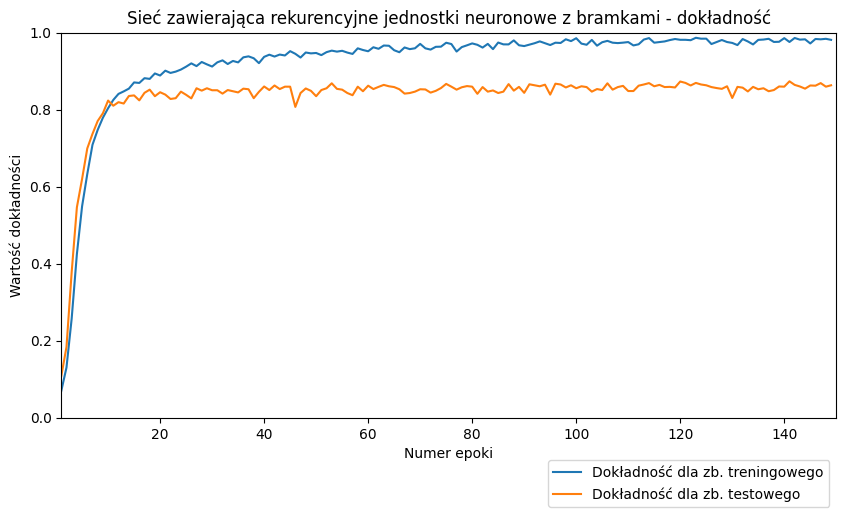

In [17]:
plot_acc(hist.history["accuracy"], hist.history["val_accuracy"])

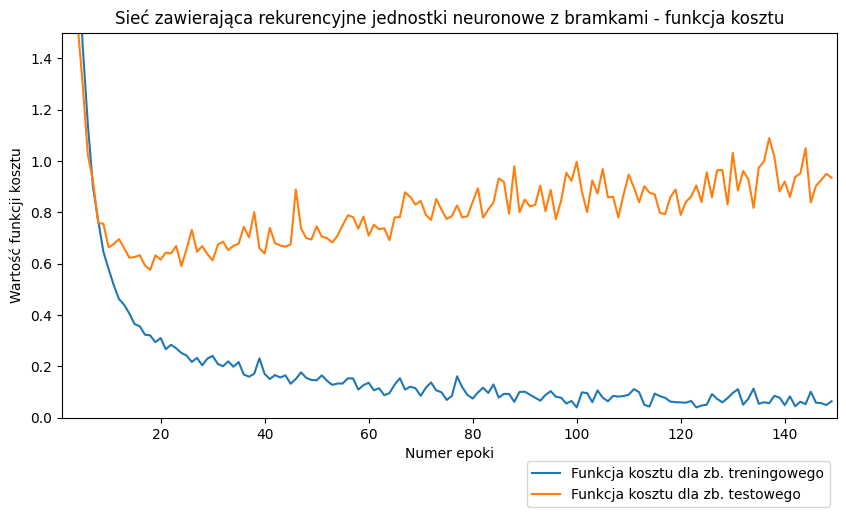

In [18]:
plot_loss(hist.history["loss"], hist.history["val_loss"])